# Variacional Univariate Gaussian

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import randn, normal, seed
from scipy.stats import norm, gamma

In [2]:
%config InlineBackend.figure_format = "retina"

In this notebook we look at a factorized variational approximation to a Gaussian Distribution.

Let $\mathcal D= \{x_n\}_{n=1}^N$ i.i.d. random variables such that $x_n\sim \mathcal N(\mu, \tau^{-1})$. Our goal is to find a posterior distribution 

$$
    p(\mu, \tau | \mathcal D) \propto p(\tau)p(\mu|\tau) p(\mathcal D | \mu, \tau)
$$

With
* $p(\tau) = \text{Gam}(\tau|a_0, b_0)$
* $p(\mu|\tau) = \mathcal N(\mu|\mu_0, (\lambda_0\tau)^{-1})$
* $p(\mathcal D | \mu, \tau) = \prod_{n=1}^N \mathcal{N}(x_n | \mu, \tau^{-1})$

To find such posterior, we assume a factorized variational approximation to $p$ given by

$$
    q(\mu,\tau) = q^*_\mu(\mu) q^*_\tau(\tau)
$$


Since the optimum factors of a factorized variational approximation follow the relation

$$
    \log q^*_j({\bf z}_j) = \mathbb{E}_{m\neq j}[\log p({\bf z})] + C,
$$

It follows that

$$
    q^*_\mu(\mu) = \mathcal{N}\left(\mu \ \big | \frac{N\bar x + \mu_0}{N + \lambda_0}, [N + \lambda_0]\mathbb{E}[\tau]\right)
$$


$$
    q^*_\tau(\tau) = \text{Gam}\left(\tau \ \big | a_0 + \frac{N}{2}, b_0 + \frac{1}{2}\mathbb{E}\left[\lambda_0\tau(\mu - \mu_0)^2 + \sum_{n=1}^N(x_n - \mu)^2\right] \right)
$$

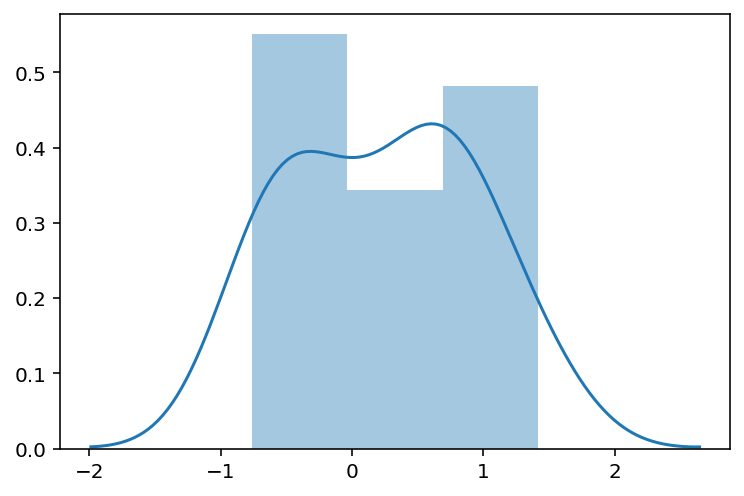

In [173]:
seed(314)
N = 20
mu, tau = 0, 1.5
sigma = np.sqrt(1 / tau)
D = normal(loc=mu, scale=sigma, size=N)

sns.distplot(D)

The true posterior is given by a Normal-Gamma Distribution

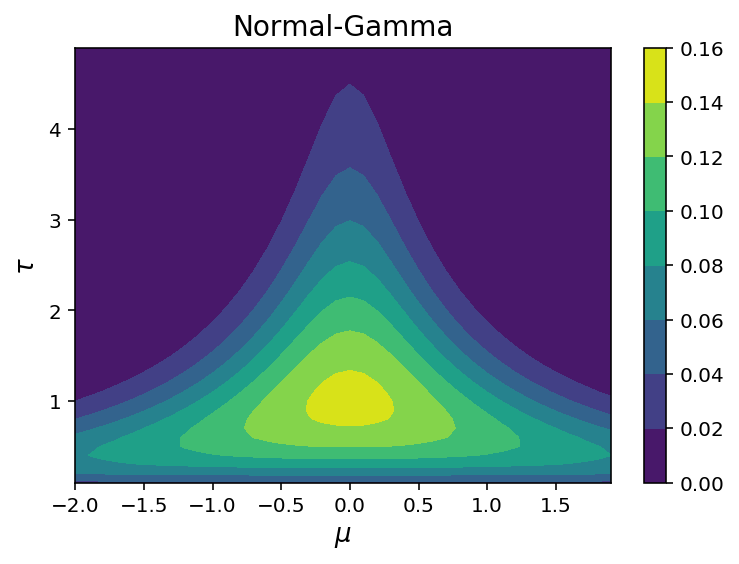

In [174]:
def norm_gamma(x, mu, lam, a, b):
    mux, taux = x
    
    pmu = norm.pdf(mux, loc=mu, scale=1 / (taux * lam))
    ptau = gamma.pdf(taux, a=a, scale=b)
    
    return pmu * ptau

a, b = 1, 1
mu, tau = 0, 1

X = np.mgrid[-2:2:0.1, 0.1:5:0.1]
Z = np.apply_along_axis(norm_gamma, 0, X,
                        mu=mu, lam=tau, a=a, b=b)

plt.title("Normal-Gamma", fontsize=14)
plt.contourf(*X, Z)
plt.xlabel(r"$\mu$", fontsize=13)
plt.ylabel(r"$\tau$", fontsize=13)
plt.colorbar();

In order to simplify the estimation of posterior parameters, we consider improper priors such that $\mu_0 = \lambda_0 = a_0 = b_0 = 0$

In [175]:
E_mu

738.253862676607

In [181]:
E_tau = (N - 1) / ((D - D.mean()) ** 2).sum()
E_mu = (D ** 2).sum() - N * D.mean() ** 2 + N / E_tau

def q_mu(mu, D, E_tau):
    N = len(D)
    mean = D.mean()
    variance = N * E_tau
    return norm.pdf(mu, loc=mean, scale=variance)

def q_tau(tau, D, E_mu):
    N = len(D)
    return gamma.pdf(tau, a=N/2, scale=E_mu/2)


def q(x, D, E_mu, E_tau):
    mu, tau = x
    qmu = q_mu(mu, D, E_tau)
    qtau = q_tau(tau, D, E_mu)
    
    q = qmu * qtau
    return q

In [196]:
gamma.pdf(0.4, a=N/2, scale=E_mu/(2*N))

4.568566751801596e-07

In [199]:
Xfact = np.mgrid[-2:2:0.1, 0.01:1:0.01]
Zfact = np.apply_along_axis(q, 0, Xfact, D=D, E_mu=E_mu, E_tau=E_tau)

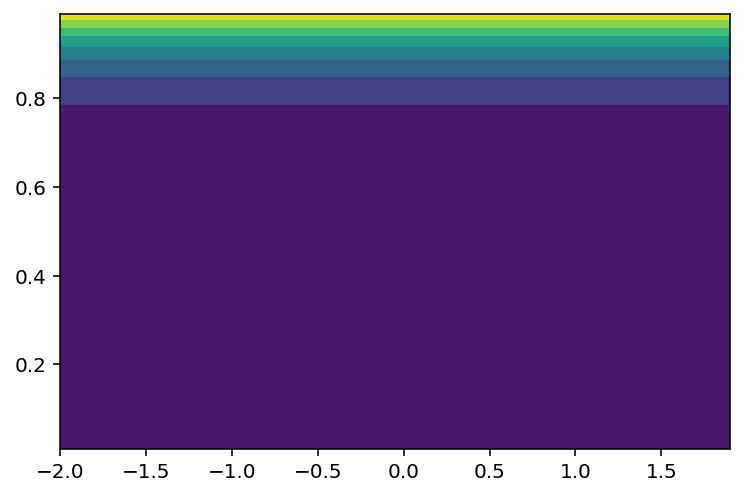

In [200]:
plt.contourf(*Xfact, Zfact)